In [2]:
import random
import numpy as np
import matplotlib.pyplot as plt

#Implementation of Easy 21

#Add a card to a hand
def draw():
    rank = random.randint(1, 10)
    if(random.randint(1, 3) == 1):
        color = -1
    else:
        color = 1
    card = rank * color
    return card

#Start a new game
def initializeEnvironment():
    #First card for dealer and player
    player = random.randint(1, 10)
    dealer = random.randint(1, 10)
    return (player, dealer)


#Take in inputs state s and action a
#Return state s', boolean done and reward r
def step(s, a):
    player = s[0]
    dealer = s[1]

    #Player's turn
    if(a == 1):
        player += draw()
        if(player > 21 or player < 1):
            return ((player, dealer), True, -1)
        else:
            return ((player, dealer), False, 0)
    #Dealer's turn
    elif(a == 0):
        while(True):    
            dealer += draw()    
            if(dealer > 21 or dealer < 1):
                return (s, True, 1) 
            elif(dealer >= 17):
                if(dealer > player):
                    return (s, True, -1)
                elif(dealer < player):  
                    return (s, True, 1)
                elif(dealer == player):
                    return (s, True, 0)

Done: 0.0 %
Done: 10.0 %
Done: 20.0 %
Done: 30.0 %
Done: 40.0 %
Done: 50.0 %
Done: 60.0 %
Done: 70.0 %
Done: 80.0 %
Done: 90.0 %
Getting ready to test target policy
Win rate 52.66 %
Loss rate 46.94 %
Draw rate 0.40 %


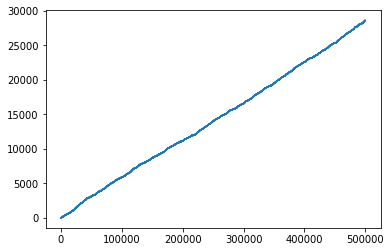

In [11]:
#Monte-Carlo Control in Easy21 

#Initialize state space               
playerSpace = [i+1 for i in range(21)]
dealerSpace = [i+1 for i in range(10)]
stateSpace = []
for hand in playerSpace:
    for card in dealerSpace:
        stateSpace.append((hand, card)) 

#Initialize value array and counters 
values = np.zeros((21, 10, 2)) #Values for all state-action pairs
Nsa = np.zeros((21, 10, 2)) #Number of times action a has been selected from state s
Ns = np.zeros((21, 10)) #Number of times state s has been visited

#Randomly choose actions for target policy
targetPolicy = {}
for state in stateSpace:
    valueOfState = values[state[0]-1][state[1]-1]
    bestAction = np.random.choice(np.where(valueOfState == valueOfState.max())[0])     
    targetPolicy[state] = bestAction

#Training section
N0 = 100
numEpisodes = 5000000
for i in range(numEpisodes):
    if(i % (numEpisodes / 10) == 0):
        print("Done:", 100 * (i / numEpisodes),"%")
    memory = []
    behaviourPolicy = {}
    #Initialize a behaviour policy epsilon greedily from the target policy
    for s in stateSpace:
        epsilon = N0 / (N0 + Ns[s[0]-1][s[1]-1])
        if(random.random() < 1 - epsilon):
            behaviourPolicy[s] = targetPolicy[s]
        else:
            if(random.random() < 0.5):
                behaviourPolicy[s] = 0
            else:
                behaviourPolicy[s] = 1
    #Make a new game
    state = initializeEnvironment()
    done = False
    #Play through the game and store every step in memory
    while not done:
        action = behaviourPolicy[state]
        state_, done, reward = step(state, action)
        memory.append((state[0], state[1], action, reward))
        state = state_
    
    G = 0 #Reward value
    #Go backwards through the memory update value array and target policy
    for player, dealer, action, reward in reversed(memory):
        G += reward
        state = (player, dealer)
        Nsa[player-1][dealer-1][action] += 1
        values[player-1][dealer-1][action] += ((1 /  Nsa[player-1][dealer-1][action]) * (G - values[player-1][dealer-1][action]))
        bestAction = np.random.choice(np.where(values[player-1][dealer-1] == values[player-1][dealer-1].max())[0]) 
        targetPolicy[state] = bestAction
        if(action != targetPolicy[state]):
            break

#Testing section
numEpisodes = int(numEpisodes/10)
rewards = np.zeros(numEpisodes)
totalReward = 0
wins = 0
losses = 0
draws = 0
print('Getting ready to test target policy')   
for i in range(numEpisodes):
    state = initializeEnvironment()
    done = False
    while not done:
        action = targetPolicy[state]
        state_, done, reward = step(state, action)
        state = state_
    totalReward += reward
    rewards[i] = totalReward

    if reward >= 1:
        wins += 1
    elif reward == 0:
        draws += 1
    elif reward == -1:
        losses += 1

wins /= numEpisodes
losses /= numEpisodes
draws /= numEpisodes
print("Win rate", "%.2f" % (wins*100), "%")
print("Loss rate", "%.2f" % (losses*100), "%")
print("Draw rate", "%.2f" % (draws*100), "%")
plt.plot(rewards)
plt.show()  



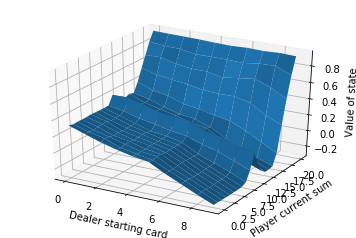

In [13]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

bestval = np.amax(values,axis=2)
fig = plt.figure()
ax = fig.gca(projection='3d')
x = range(10)
y = range(21)
X, Y = np.meshgrid(x, y)
ax.plot_surface(X, Y, bestval)
ax.set_xlabel("Dealer starting card")
ax.set_ylabel("Player current sum")
ax.set_zlabel("Value of state")
plt.show()
fig.savefig('5milEpisodesMC.png')

In [42]:
#Sarsa(λ)
realvalues = np.amax(values,axis=2)
mean_sqr_error = np.zeros(9)
for k in range(0, 11):
    lam = k/10.0 #run for lambda = {0.0, 0.1 ... 0.9, 1.0}
    #Initialize state space               
    playerSpace = [i+1 for i in range(21)]
    dealerSpace = [i+1 for i in range(10)]
    stateSpace = []
    for hand in playerSpace:
        for card in dealerSpace:
            stateSpace.append((hand, card)) 

    #Initialize value array and counters 
    values_sarsa = np.zeros((21, 10, 2)) #Values for all state-action pairs
    Nsa = np.zeros((21, 10, 2)) #Number of times action a has been selected from state s
    Ns = np.zeros((21, 10)) #Number of times state s has been visited
    E = np.zeros((21, 10, 2))
    #Randomly choose actions for target policy
    targetPolicy = {}
    for state in stateSpace:
        valueOfState = values_sarsa[state[0]-1][state[1]-1]
        bestAction = np.random.choice(np.where(valueOfState == valueOfState.max())[0])     
        targetPolicy[state] = bestAction

    #Training section
    N0 = 100
    numEpisodes = 1000
    for i in range(numEpisodes):
    
        behaviourPolicy = {}
        for s in stateSpace:
            epsilon = N0 / (N0 + Ns[s[0]-1][s[1]-1])
            if(random.random() < 1 - epsilon):
                behaviourPolicy[s] = targetPolicy[s]
            else:
                if(random.random() < 0.5):
                    behaviourPolicy[s] = 0
                else:
                    behaviourPolicy[s] = 1
        state = initializeEnvironment()
        action = behaviourPolicy[state]
        done = False

        while not done:
            state_, done, reward = step(state, action)
            if not done:
                action_ = behaviourPolicy[state_]
                theta = reward + values_sarsa[state_[0]-1][state_[1]-1][action_] - values_sarsa[state[0]-1][state[1]-1][action]
            else:
                theta = reward
            E[state[0]-1][state[1]-1][action] += 1
            Nsa[state[0]-1][state[1]-1][action] += 1
            Ns[state[0]-1][state[1]-1] += 1
            alpha =  1 / Nsa[state[0]-1][state[1]-1][action]
            for s in stateSpace:
                for a in range(2):
                    values_sarsa[s[0]-1][s[1]-1][a] += alpha * theta * E[s[0]-1][s[1]-1][a]
                    E[s[0]-1][s[1]-1][a] = lam * E[s[0]-1][s[1]-1][a]
                    bestAction = np.random.choice(np.where(values_sarsa[s[0]-1][s[1]-1][a] == values_sarsa[s[0]-1][s[1]-1][a].max())[0]) 
                    targetPolicy[state] = bestAction
            if not done:
                state = state_
                action = action_
        if(k == 0):
            sarsa_maxvalues = np.amax(values_sarsa,axis=2)
            for i in range(len(sarsa_maxvalues[0])):
                for j in range(len(sarsa_maxvalues[1])):
                    mean_sqr_error_0[i] += pow((sarsa_maxvalues[i][j] - realvalues[i][j]),2)
        elif(k == 10):
            sarsa_maxvalues = np.amax(values_sarsa,axis=2)
            for i in range(len(sarsa_maxvalues[0])):
                for j in range(len(sarsa_maxvalues[1])):
                    mean_sqr_error_0[i] += pow((sarsa_maxvalues[i][j] - realvalues[i][j]),2)
    #Calculate mean-squared error
    if(k != 0 and k != 10):
        sarsa_maxvalues = np.amax(values_sarsa,axis=2)
        for i in range(len(sarsa_maxvalues[0])):
            for j in range(len(sarsa_maxvalues[1])):
                mean_sqr_error[k-1] += pow((sarsa_maxvalues[i][j] - realvalues[i][j]),2)
print(mean_sqr_error)
       

[ 110.61065828  107.7550806    95.72627326  141.48894994  117.8460946
  208.29911596  227.6696504   516.49853017  587.13294901]


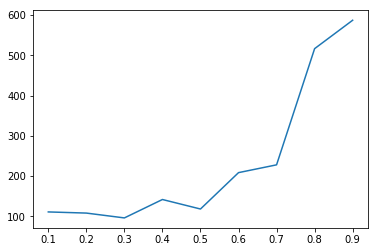

In [43]:
x = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
y = mean_sqr_error
plt.plot(x, y)
plt.show()